In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# load dataset
df = pd.read_csv('UberDrives.csv')
df.head()

,START_DATE*,END_DATE*,CATEGORY*,START*,STOP*,MILES*,PURPOSE*
0,1/1/2016 21:11,1/1/2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,1/2/2016 1:25,1/2/2016 1:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,1/2/2016 20:25,1/2/2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,1/5/2016 17:31,1/5/2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,1/6/2016 14:42,1/6/2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   START_DATE*  1156 non-null   object 
 1   END_DATE*    1155 non-null   object 
 2   CATEGORY*    1155 non-null   object 
 3   START*       1155 non-null   object 
 4   STOP*        1155 non-null   object 
 5   MILES*       1156 non-null   float64
 6   PURPOSE*     653 non-null    object 
dtypes: float64(1), object(6)
memory usage: 63.3+ KB


In [10]:
# Clean column names
df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_\s]', '', regex=True)  # remove special chars like *
df.columns = df.columns.str.strip()  # remove spaces
df.columns = df.columns.str.replace(' ', '_')  # replace spaces with underscores for safety

print("✅ Cleaned column names:")
print(df.columns.tolist())

✅ Cleaned column names:
['START_DATE', 'END_DATE', 'CATEGORY', 'START', 'STOP', 'MILES', 'PURPOSE']


In [11]:
import re

pattern = r'[^a-zA-Z0-9\s\.\,\-\:\/]'

for col in df.columns:
    mask = df[col].astype(str).str.contains(pattern, regex=True)
    if mask.any():
        print(f"⚠️ Suspicious characters found in column: {col}")
        display(df.loc[mask, col].head(10))

⚠️ Suspicious characters found in column: START


21     Hell's Kitchen
140        R?walpindi
141        R?walpindi
656        R?walpindi
670        R?walpindi
679        R?walpindi
696        R?walpindi
697        R?walpindi
763        R?walpindi
788        R?walpindi
Name: START, dtype: object

⚠️ Suspicious characters found in column: STOP


20     Hell's Kitchen
139        R?walpindi
140        R?walpindi
154        R?walpindi
669        R?walpindi
678        R?walpindi
695        R?walpindi
696        R?walpindi
750        R?walpindi
769        R?walpindi
Name: STOP, dtype: object

⚠️ Suspicious characters found in column: PURPOSE


558    Charity ($)
Name: PURPOSE, dtype: object

In [12]:
df = df.applymap(lambda x: re.sub(pattern, '', str(x)) if isinstance(x, str) else x)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [13]:
for col in df.columns:
    mask = df[col].astype(str).str.contains(pattern, regex=True)
    if mask.any():
        print(f"Still found in: {col}")
    else:
        print(f"✅ {col} is clean.")

✅ START_DATE is clean.
✅ END_DATE is clean.
✅ CATEGORY is clean.
✅ START is clean.
✅ STOP is clean.
✅ MILES is clean.
✅ PURPOSE is clean.


In [15]:
# Clean column names
df.columns = (
    df.columns.str.strip()        # remove leading/trailing spaces
             .str.replace('*', '', regex=False)
             .str.replace(' ', '_')
)

# Clean string-based columns
for col in df.select_dtypes(include='object').columns:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(r'[^\w\s\-,.:/]', '', regex=True)  # remove $, ?, %, etc.
        .str.strip()
    )

# Clean numeric columns (only those that exist)
num_cols = [col for col in ['MILES', 'DURATION_MINUTES'] if col in df.columns]
for col in num_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(r'[^0-9\.]', '', regex=True)
        .replace('', '0')
        .astype(float)
    )

# Confirm
print("✅ Cleaned columns:", df.columns.tolist())
print(df.head())


✅ Cleaned columns: ['START_DATE', 'END_DATE', 'CATEGORY', 'START', 'STOP', 'MILES', 'PURPOSE']
       START_DATE        END_DATE  CATEGORY        START             STOP  \
0  1/1/2016 21:11  1/1/2016 21:17  Business  Fort Pierce      Fort Pierce   
1   1/2/2016 1:25   1/2/2016 1:37  Business  Fort Pierce      Fort Pierce   
2  1/2/2016 20:25  1/2/2016 20:38  Business  Fort Pierce      Fort Pierce   
3  1/5/2016 17:31  1/5/2016 17:45  Business  Fort Pierce      Fort Pierce   
4  1/6/2016 14:42  1/6/2016 15:49  Business  Fort Pierce  West Palm Beach   

   MILES          PURPOSE  
0    5.1   Meal/Entertain  
1    5.0              nan  
2    4.8  Errand/Supplies  
3    4.7          Meeting  
4   63.7   Customer Visit  


In [18]:
# Convert date columns to datetime
df['START_DATE'] = pd.to_datetime(df['START_DATE'], errors='coerce')
df['END_DATE'] = pd.to_datetime(df['END_DATE'], errors='coerce')

# Compute trip duration in minutes
df['DURATION_MINUTES'] = (df['END_DATE'] - df['START_DATE']).dt.total_seconds() / 60

# Extract useful datetime features
df['DATE'] = df['START_DATE'].dt.date
df['MONTH'] = df['START_DATE'].dt.month_name()
df['DAY'] = df['START_DATE'].dt.day
df['HOUR'] = df['START_DATE'].dt.hour
df['WEEKDAY'] = df['START_DATE'].dt.day_name()
df['IS_WEEKEND'] = df['WEEKDAY'].isin(['Saturday', 'Sunday'])

In [19]:
# Check missing values
missing = df.isnull().sum().to_frame('Missing_Count')
missing['Missing_%'] = round((missing['Missing_Count'] / len(df)) * 100, 2)
print("📊 Missing Values Summary:")
print(missing)

# Quick descriptive stats
print("\n📈 Basic Statistics:")
print(df[['MILES', 'DURATION_MINUTES']].describe())

# Step 6: Category and Purpose frequencies
print("\n🚗 Category Distribution:")
print(df['CATEGORY'].value_counts(dropna=False))

print("\n🎯 Top Trip Purposes:")
print(df['PURPOSE'].value_counts(dropna=False).head(10))

print("\n📍 Top Start Locations:")
print(df['START'].value_counts().head(10))

print("\n🏁 Top Stop Locations:")
print(df['STOP'].value_counts().head(10))

# Step 7: Check for outliers
print("\n⚠️ Trips with missing or negative durations:")
print(df[df['DURATION_MINUTES'] <= 0].head())

📊 Missing Values Summary:
                  Missing_Count  Missing_%
START_DATE                    1       0.09
END_DATE                      1       0.09
CATEGORY                      0       0.00
START                         0       0.00
STOP                          0       0.00
MILES                         0       0.00
PURPOSE                       0       0.00
DURATION_MINUTES              1       0.09
DATE                          1       0.09
MONTH                         1       0.09
DAY                           1       0.09
HOUR                          1       0.09
WEEKDAY                       1       0.09
IS_WEEKEND                    0       0.00

📈 Basic Statistics:
              MILES  DURATION_MINUTES
count   1156.000000       1155.000000
mean      21.115398         23.243290
std      359.299007         27.318277
min        0.500000          0.000000
25%        2.900000         10.000000
50%        6.000000         16.000000
75%       10.400000         27.500000
max 

In [20]:
# Category breakdown
df['CATEGORY'].value_counts(normalize=True, dropna=False)

# Purpose breakdown (top 10)
df['PURPOSE'].value_counts(dropna=False).head(10)

# Sample of highest-mile trips (to confirm outliers)
df[['START', 'STOP', 'MILES', 'DURATION_MINUTES']].sort_values(by='MILES', ascending=False).head(5)


,START,STOP,MILES,DURATION_MINUTES
1155,nan,nan,12204.7,NaN
269,Latta,Jacksonville,310.3,330.0
270,Jacksonville,Kissimmee,201.0,165.0
881,Asheville,Mebane,195.9,181.0
776,Unknown Location,Unknown Location,195.6,336.0


In [21]:
# Drop the clearly erroneous record(s)
df = df[df['MILES'] < 1000]  # Filters out the 12,204 mi outlier

In [22]:
df['CATEGORY'].value_counts(normalize=True)

CATEGORY
Business    0.933333
Personal    0.066667
Name: proportion, dtype: float64

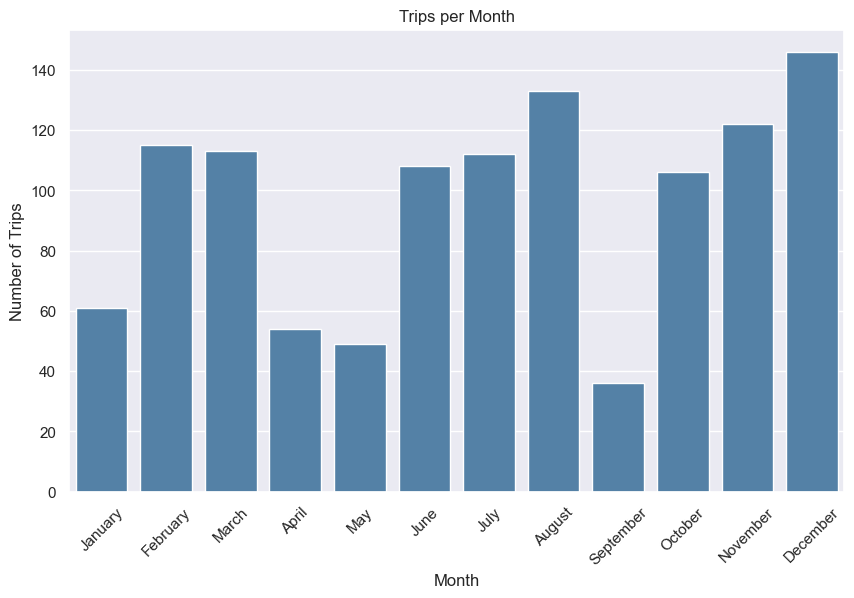

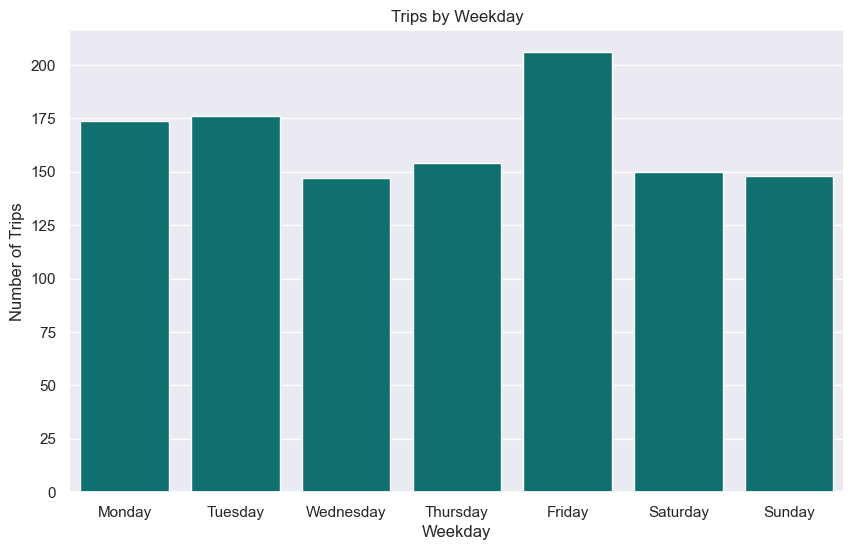

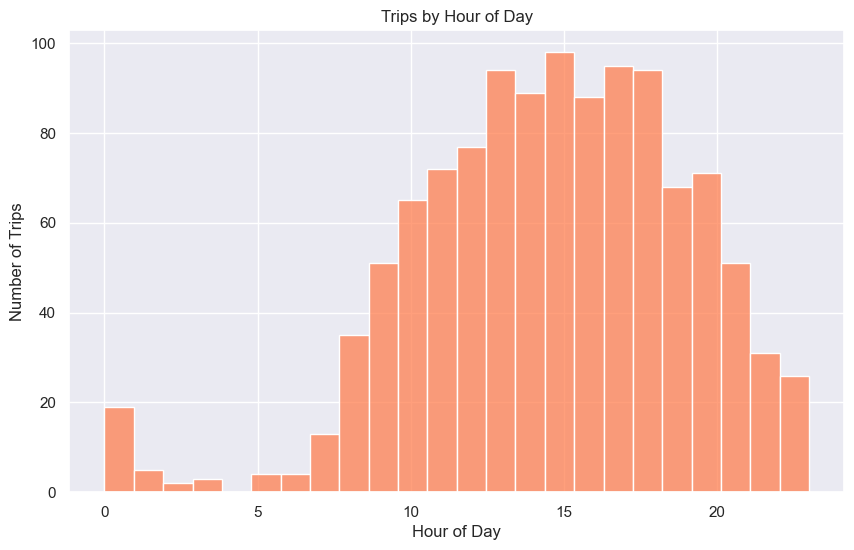

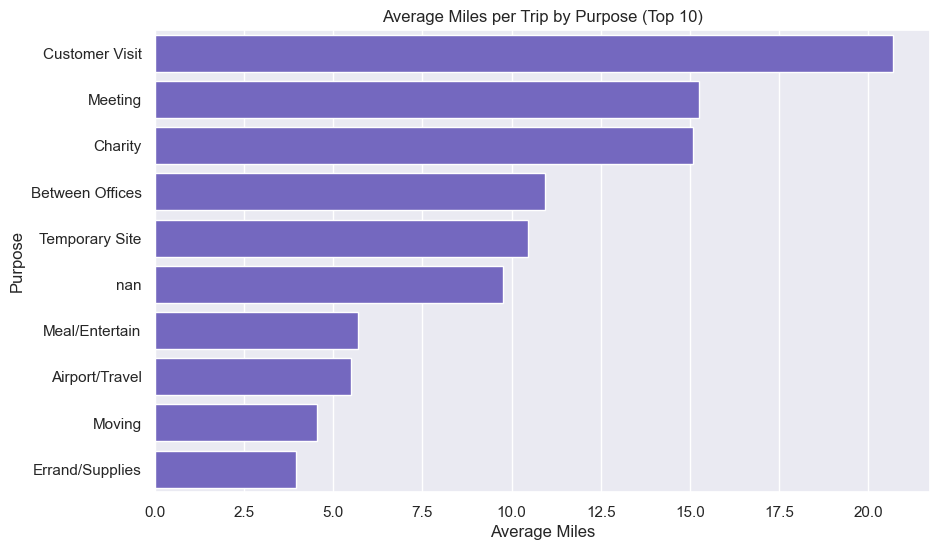

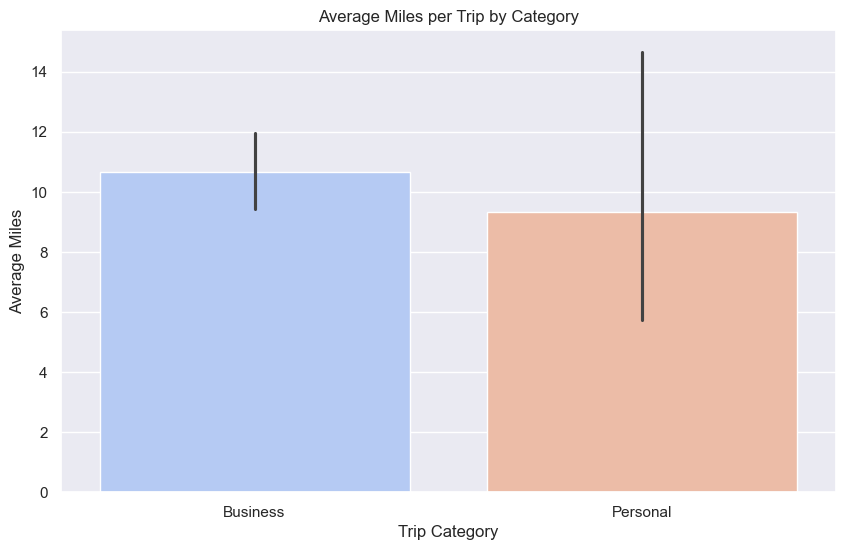

In [23]:
 # Deeper EDA & Time Patterns
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(rc={'figure.figsize':(10,6)})

#Trips by Month
month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']
monthly_trips = df['MONTH'].value_counts().reindex(month_order)
sns.barplot(x=monthly_trips.index, y=monthly_trips.values, color='steelblue')
plt.title("Trips per Month")
plt.ylabel("Number of Trips")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.show()

# Trips by Weekday
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_trips = df['WEEKDAY'].value_counts().reindex(weekday_order)
sns.barplot(x=weekday_trips.index, y=weekday_trips.values, color='teal')
plt.title("Trips by Weekday")
plt.ylabel("Number of Trips")
plt.xlabel("Weekday")
plt.show()

# Trips by Hour
sns.histplot(df['HOUR'].dropna(), bins=24, kde=False, color='coral')
plt.title("Trips by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.show()

# Average Miles by Purpose (top 10 purposes)
top_purposes = df['PURPOSE'].value_counts().head(10).index
avg_miles_by_purpose = df[df['PURPOSE'].isin(top_purposes)].groupby('PURPOSE')['MILES'].mean().sort_values(ascending=False)
sns.barplot(x=avg_miles_by_purpose.values, y=avg_miles_by_purpose.index, color='slateblue')
plt.title("Average Miles per Trip by Purpose (Top 10)")
plt.xlabel("Average Miles")
plt.ylabel("Purpose")
plt.show()

# average miles by category
sns.barplot(x='CATEGORY', y='MILES', data=df, estimator='mean', palette='coolwarm')
plt.title("Average Miles per Trip by Category")
plt.xlabel("Trip Category")
plt.ylabel("Average Miles")
plt.show()


📍 Top Start Locations:
 START
Cary                201
Unknown Location    148
Morrisville          85
Whitebridge          68
Islamabad            57
Durham               37
Lahore               36
Raleigh              28
Karchi               27
Westpark Place       17
Name: count, dtype: int64

🏁 Top Stop Locations:
 STOP
Cary                203
Unknown Location    149
Morrisville          84
Whitebridge          65
Islamabad            58
Durham               36
Lahore               36
Raleigh              29
Karchi               26
Apex                 17
Name: count, dtype: int64


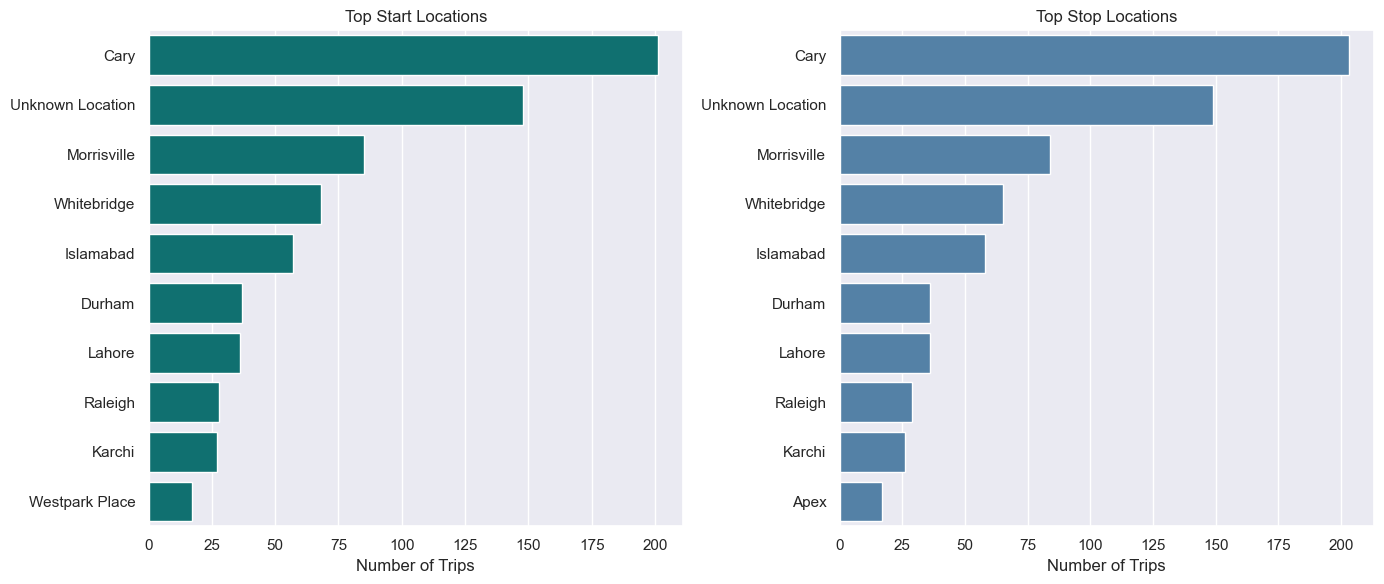

In [24]:
# Location & Distance Patterns

# Top Start & Stop Locations

# Top 10 start locations
top_start = df['START'].value_counts().head(10)
print("📍 Top Start Locations:\n", top_start)

# Top 10 stop locations
top_stop = df['STOP'].value_counts().head(10)
print("\n🏁 Top Stop Locations:\n", top_stop)

# Barplots
fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.barplot(y=top_start.index, x=top_start.values, ax=axes[0], color='teal')
axes[0].set_title('Top Start Locations')
axes[0].set_xlabel('Number of Trips')
axes[0].set_ylabel('')

sns.barplot(y=top_stop.index, x=top_stop.values, ax=axes[1], color='steelblue')
axes[1].set_title('Top Stop Locations')
axes[1].set_xlabel('Number of Trips')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

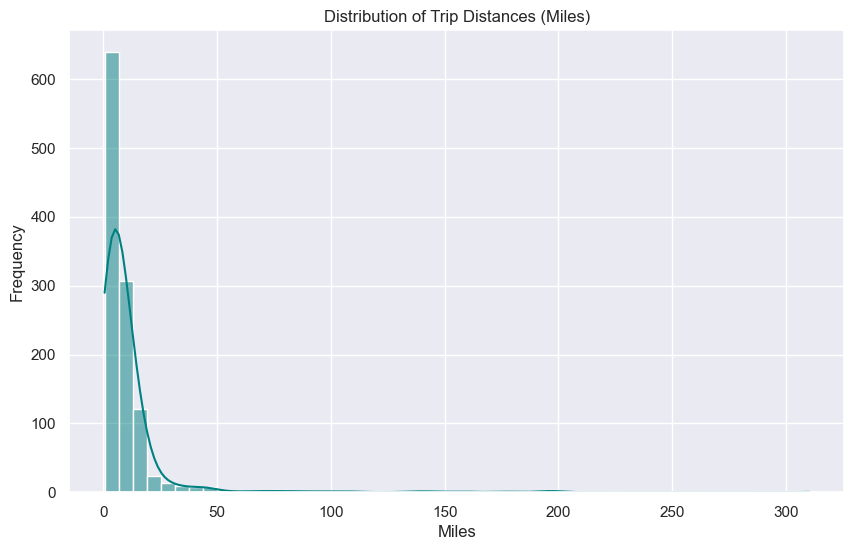

🚨 Trips with unusually high mileage (>500 miles):
Empty DataFrame
Columns: [START, STOP, MILES]
Index: []


In [ ]:
# Trip Distance & Duration Insights
plt.figure(figsize=(10,6))
sns.histplot(df['MILES'], bins=50, kde=True, color='teal')
plt.title('Distribution of Trip Distances (Miles)')
plt.xlabel('Miles')
plt.ylabel('Frequency')
plt.show()

# Identify extreme outliers
outliers = df[df['MILES'] > 500]
print("🚨 Trips with unusually high mileage (>500 miles):")
print(outliers[['START', 'STOP', 'MILES']])

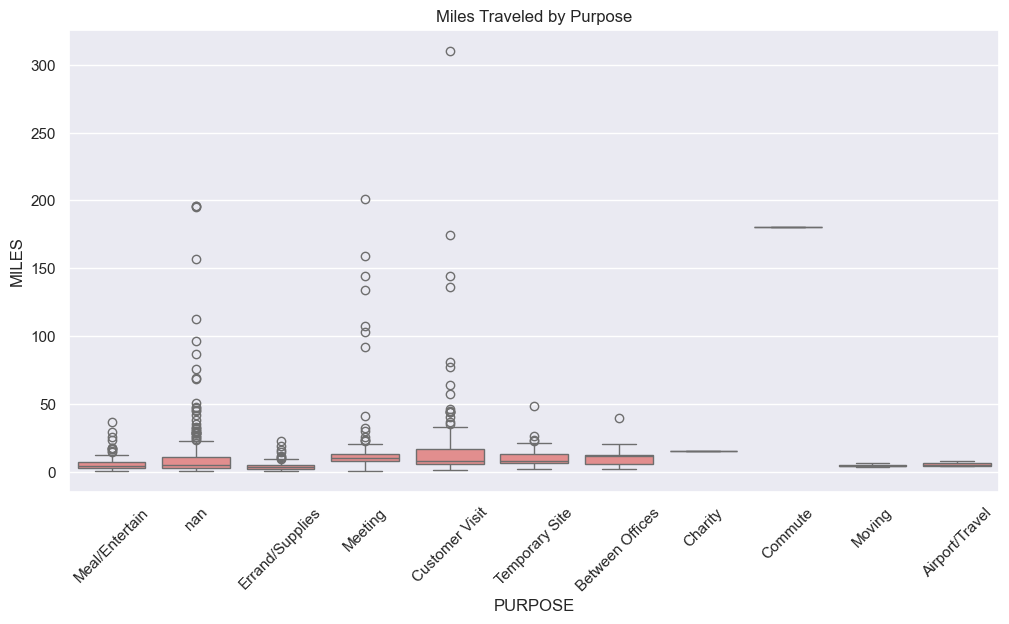

In [26]:
plt.figure(figsize=(12,6))
sns.boxplot(x='PURPOSE', y='MILES', data=df, color='lightcoral')
plt.xticks(rotation=45)
plt.title('Miles Traveled by Purpose')
plt.show()

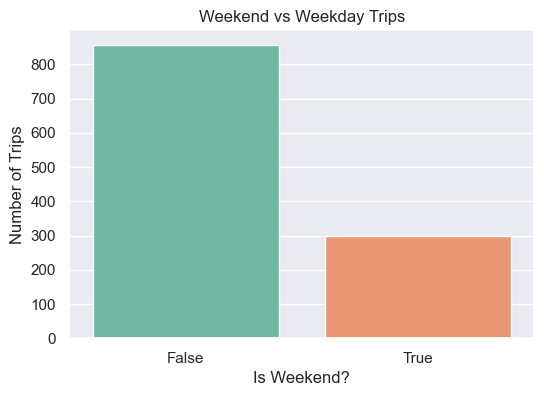

IS_WEEKEND
False    0.741991
True     0.258009
Name: proportion, dtype: float64


In [30]:
plt.figure(figsize=(6,4))
sns.countplot(x='IS_WEEKEND', data=df, palette='Set2')
plt.title('Weekend vs Weekday Trips')
plt.xlabel('Is Weekend?')
plt.ylabel('Number of Trips')
plt.show()

print(df['IS_WEEKEND'].value_counts(normalize=True))


In [42]:
# Convert to datetime if not already
df['START_DATE'] = pd.to_datetime(df['START_DATE'], errors='coerce')
df['END_DATE'] = pd.to_datetime(df['END_DATE'], errors='coerce')

# Extract time features
df['hour'] = df['START_DATE'].dt.hour
df['day_of_week'] = df['START_DATE'].dt.dayofweek  # Monday=0, Sunday=6

df[['START_DATE', 'hour', 'day_of_week']].head()

,START_DATE,hour,day_of_week
0,2016-01-01 21:11:00,21,4
1,2016-01-02 01:25:00,1,5
2,2016-01-02 20:25:00,20,5
3,2016-01-05 17:31:00,17,1
4,2016-01-06 14:42:00,14,2


In [43]:
# clustering using k-means

from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
cluster_features = df[['MILES', 'DURATION_MINUTES', 'hour', 'day_of_week']].copy()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_features)

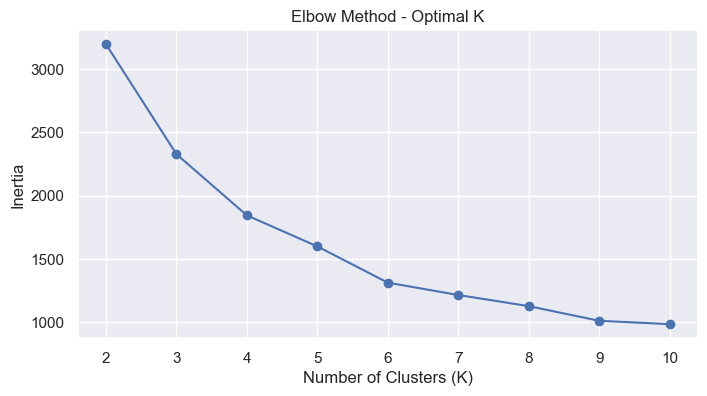

In [44]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_values = range(2, 11)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method - Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

In [45]:
# Assuming the elbow shows K=3 (you’ll confirm after plotting)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [46]:
cluster_summary = df.groupby('Cluster')[['MILES', 'DURATION_MINUTES', 'hour', 'day_of_week']].mean().round(2)
print(cluster_summary)

          MILES  DURATION_MINUTES   hour  day_of_week
Cluster                                              
0          8.56             21.10  14.72         4.44
1          7.54             19.83  14.61         0.94
2        142.93            168.95  15.86         4.14


In [47]:
from sklearn.cluster import KMeans

# Choose k based on elbow method or intuition (say 3)
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

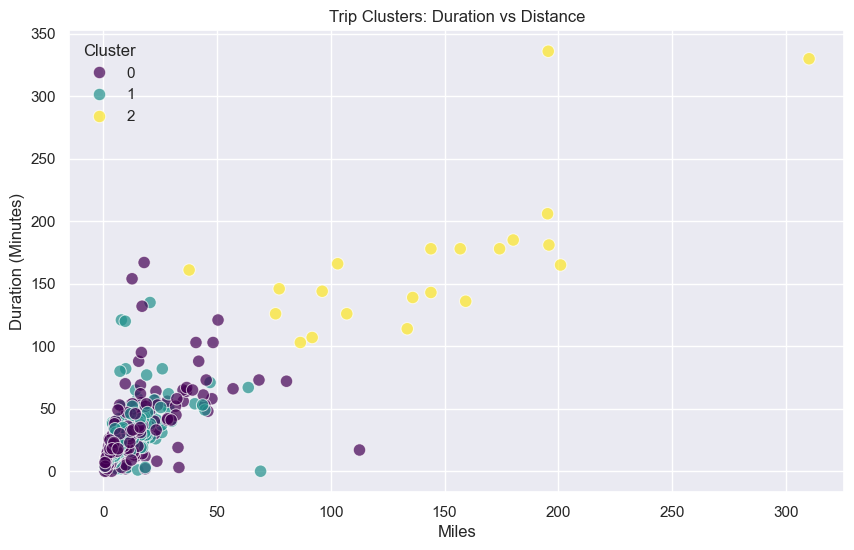

In [48]:
# Visualize Clusters (2D — Duration vs Distance)

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df, 
    x='MILES', 
    y='DURATION_MINUTES', 
    hue='cluster', 
    palette='viridis', 
    s=80, 
    alpha=0.7
)
plt.title('Trip Clusters: Duration vs Distance')
plt.xlabel('Miles')
plt.ylabel('Duration (Minutes)')
plt.legend(title='Cluster')
plt.show()
